# Load Dataset

In [1]:
# Import Modules
# Data Analysis and Visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
df = pd.read_csv('daily_revenue.csv')
df.head()

,date,revenue,discount_rate,coupon_rate
0,1/1/2018,"6,270,839",34.27%,1.09%
1,2/1/2018,"8,922,076",30.87%,1.08%
2,3/1/2018,"8,446,101",28.11%,1.01%
3,4/1/2018,"7,785,798",27.32%,0.96%
4,5/1/2018,"6,375,303",25.70%,0.90%


In [3]:
# see the information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1795 non-null   object
 1   revenue        1795 non-null   object
 2   discount_rate  1795 non-null   object
 3   coupon_rate    1795 non-null   object
dtypes: object(4)
memory usage: 56.2+ KB


In [4]:
# convert date into datetime object
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# convert revenue, discount_rate, and coupon_rate into float
df['revenue'] = df['revenue'].str.replace(',','').astype('float')
df['discount_rate'] = df['discount_rate'].str.replace('%','').astype('float') / 100
df['coupon_rate'] = df['coupon_rate'].str.replace('%','').astype('float')

# set date into index
df.set_index('date', inplace=True)
df = df.asfreq('D')

# see the result
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,0.3427,1.09
2018-01-02,8922076.0,0.3087,1.08
2018-01-03,8446101.0,0.2811,1.01
2018-01-04,7785798.0,0.2732,0.96
2018-01-05,6375303.0,0.2570,0.90


In [5]:
# see the information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
dtypes: float64(3)
memory usage: 56.1 KB


In [6]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

# Exploartory Data Analysis

## Plot Dataset

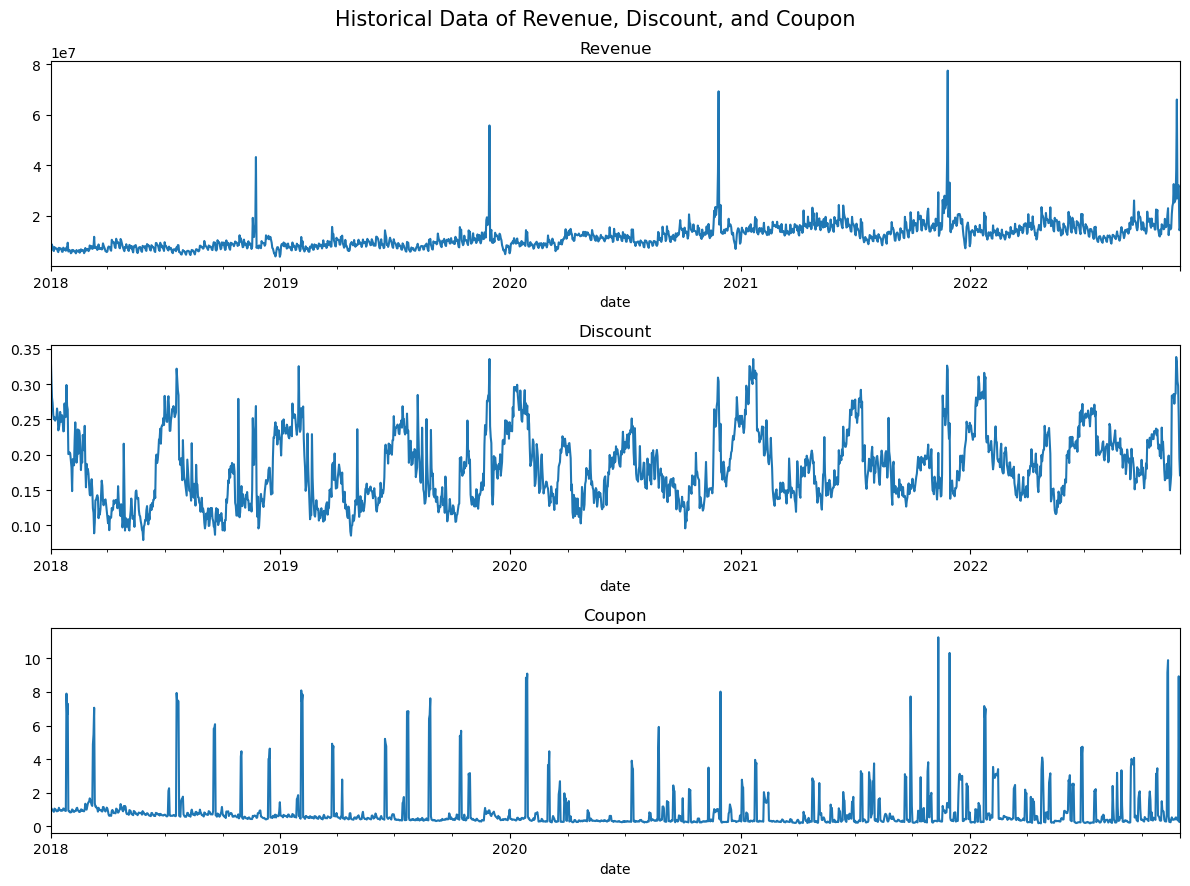

In [7]:
fig, ax = plt.subplots(3,1, figsize=(12, 9))
ax = ax.flatten()

df.revenue.plot(ax=ax[0], title='Revenue')
df.discount_rate.plot(ax=ax[1], title='Discount')
df.coupon_rate.plot(ax=ax[2], title='Coupon')

plt.suptitle('Historical Data of Revenue, Discount, and Coupon', size=15)
plt.tight_layout()
plt.show();

## Check Correlations

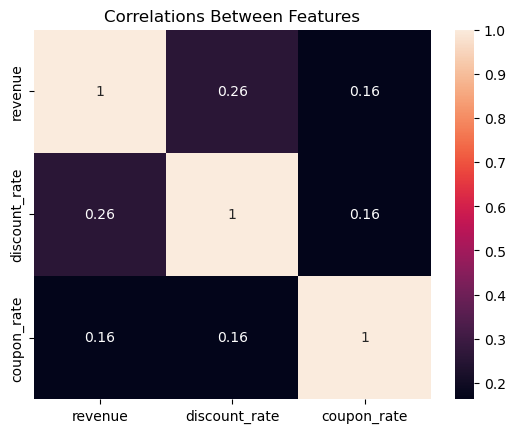

In [8]:
sns.heatmap(df.corr(), annot=True)
plt.title("Correlations Between Features")
plt.show();

## Check Trend and Seasonality

In [9]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
def plot_seasonal(df, column_name='revenue', figsize=(12, 4)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize, sharey=True)
    
    month_plot(df[column_name].resample('ME').mean(), 
               ax=ax1)
    quarter_plot(df[column_name].resample('QE').mean(), 
                 ax=ax2)
    
    ax1.set_title("Monthly Plot", size=int(figsize[0]))
    ax2.set_title("Quarterly Plot", size=int(figsize[0]))
    plt.suptitle(f"Seasonal Plot of {column_name.title()}", size=int(1.3*figsize[0]))
    plt.tight_layout()
    plt.plot();

### Revenue Seasonal

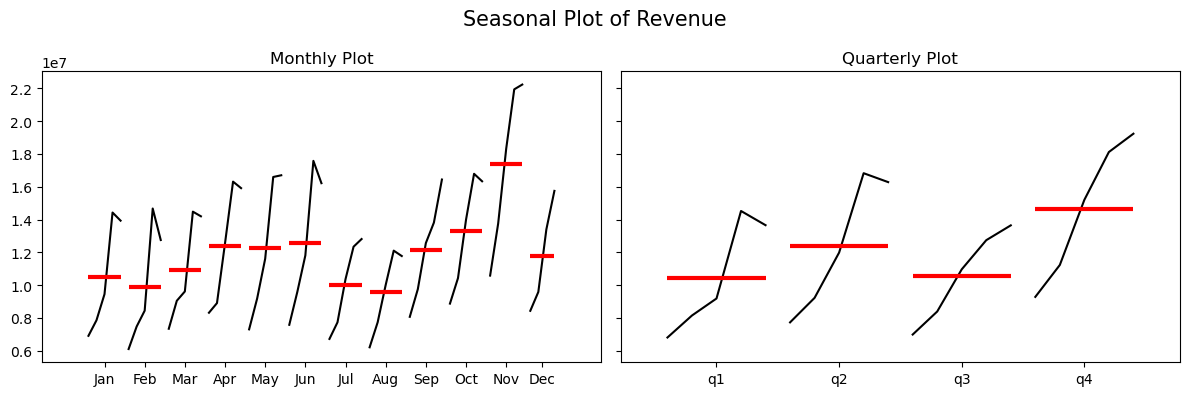

In [11]:
plot_seasonal(df, 'revenue')

In [12]:
def decompose(df, column_name='revenue', model = 'mul', period=365,
              figsize=(12, 4)):
    # Seasonal Decomposition Plots for complaint values
    # Multiplicative model type, with yearly seasonality (52 weeks)
    
    decomposition = seasonal_decompose(df[column_name],
                                       model = model,
                                       period = period)
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    
    if (model == 'mul') or (model == 'muliplicative'):
        model = 'Multiplicative'
    else: 'Additive'
    
    fig.suptitle(f"Decomposition of {column_name.title()} using {model.title()} Model Type",size=int(1.3*figsize[0]))
    plt.show()

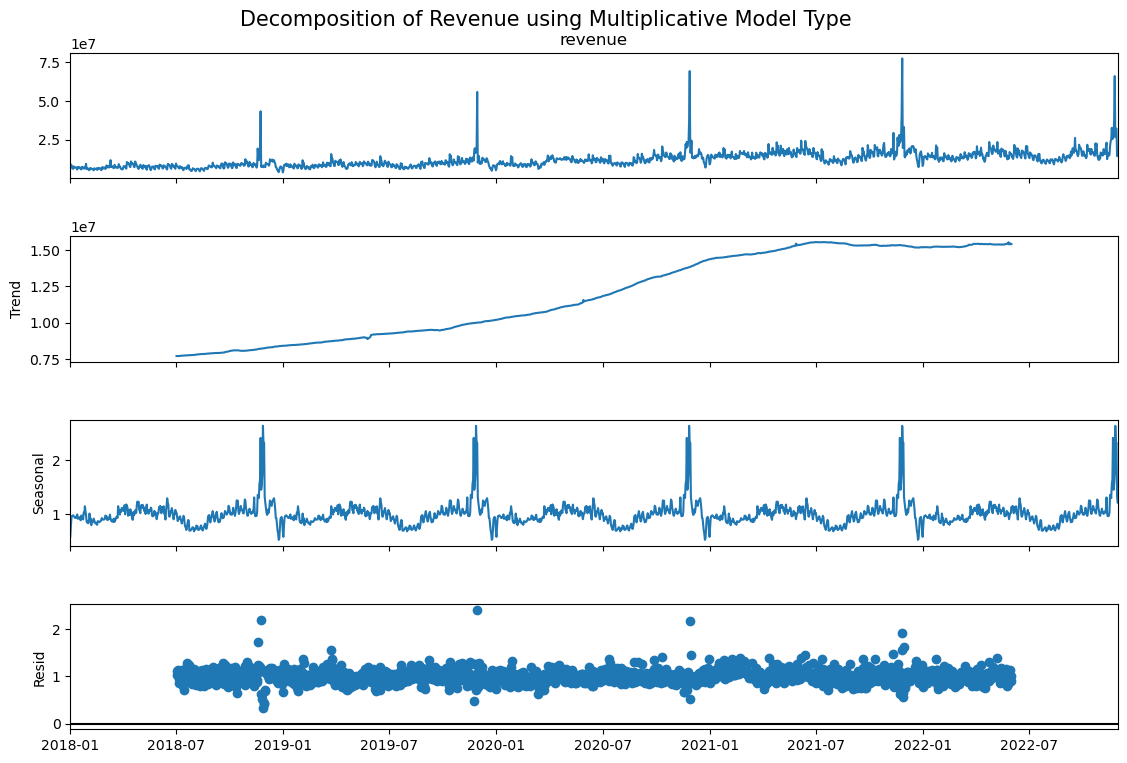

In [13]:
decompose(df, 'revenue')

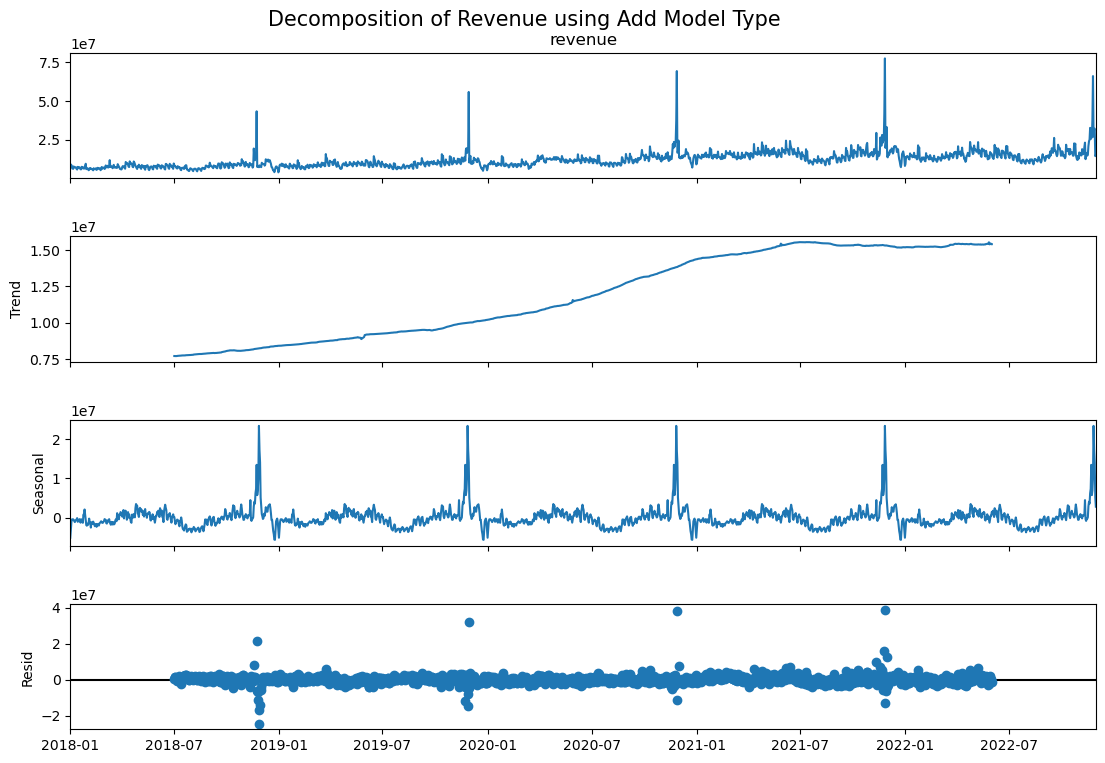

In [14]:
decompose(df, 'revenue', model='add')

### Discount Rate Seasonal

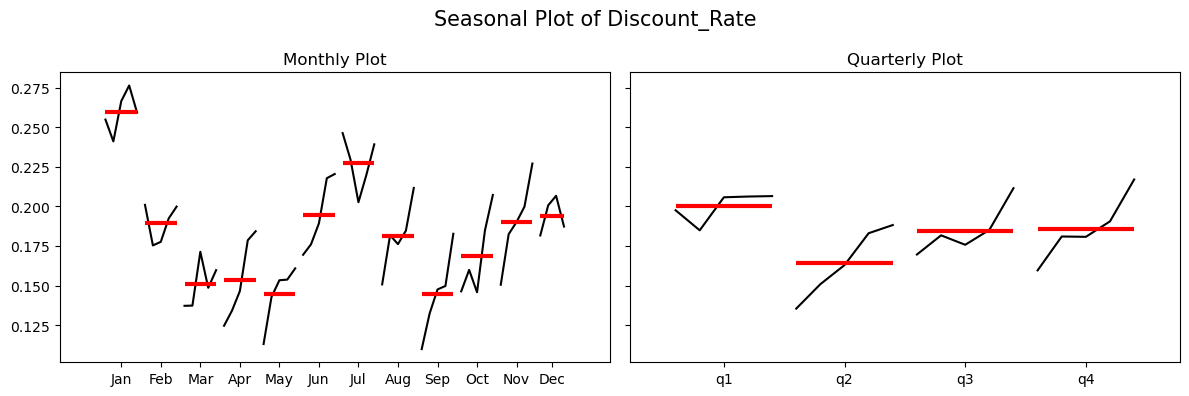

In [15]:
plot_seasonal(df, 'discount_rate')

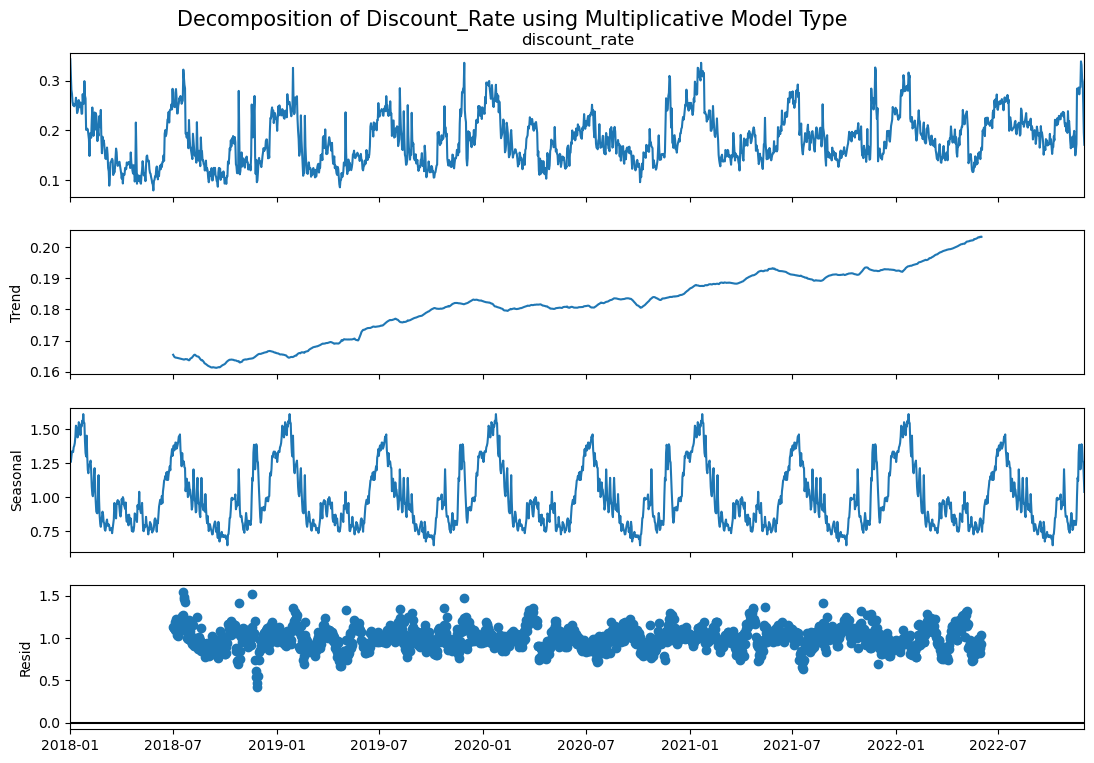

In [16]:
decompose(df, 'discount_rate')

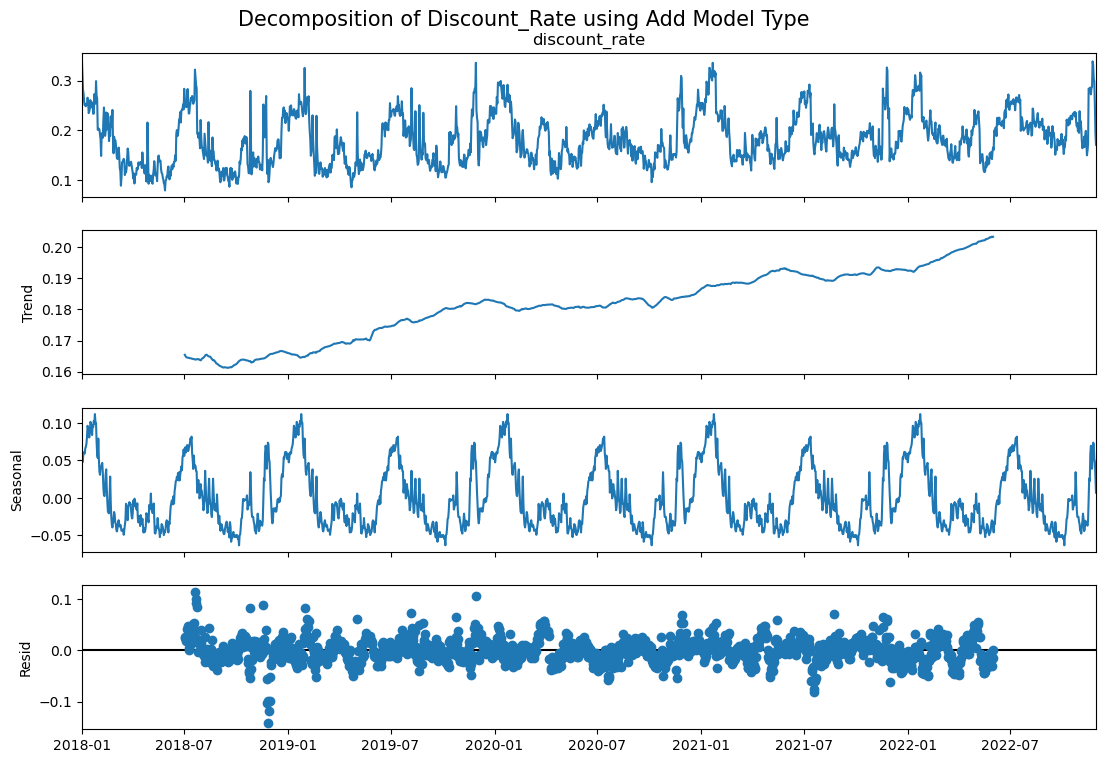

In [17]:
decompose(df, 'discount_rate', model='add')

### Coupon Rate Seasonal

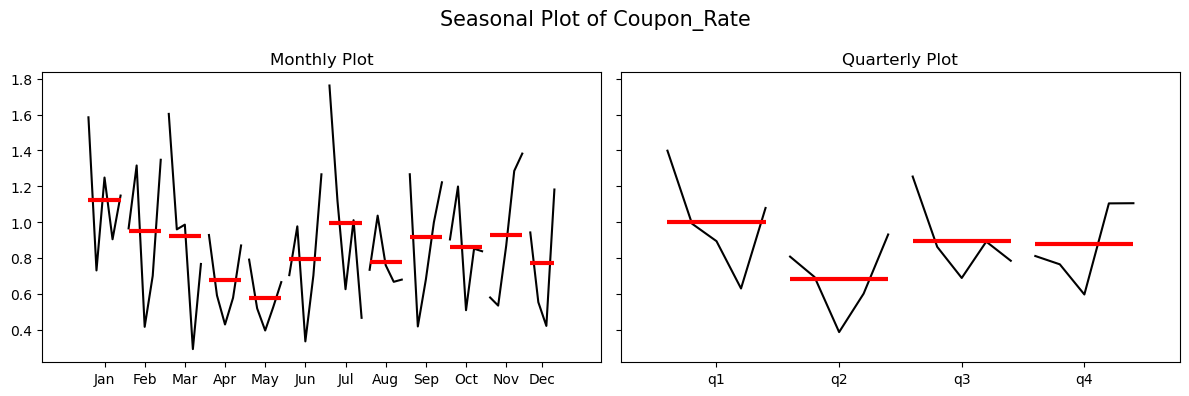

In [18]:
plot_seasonal(df, 'coupon_rate')

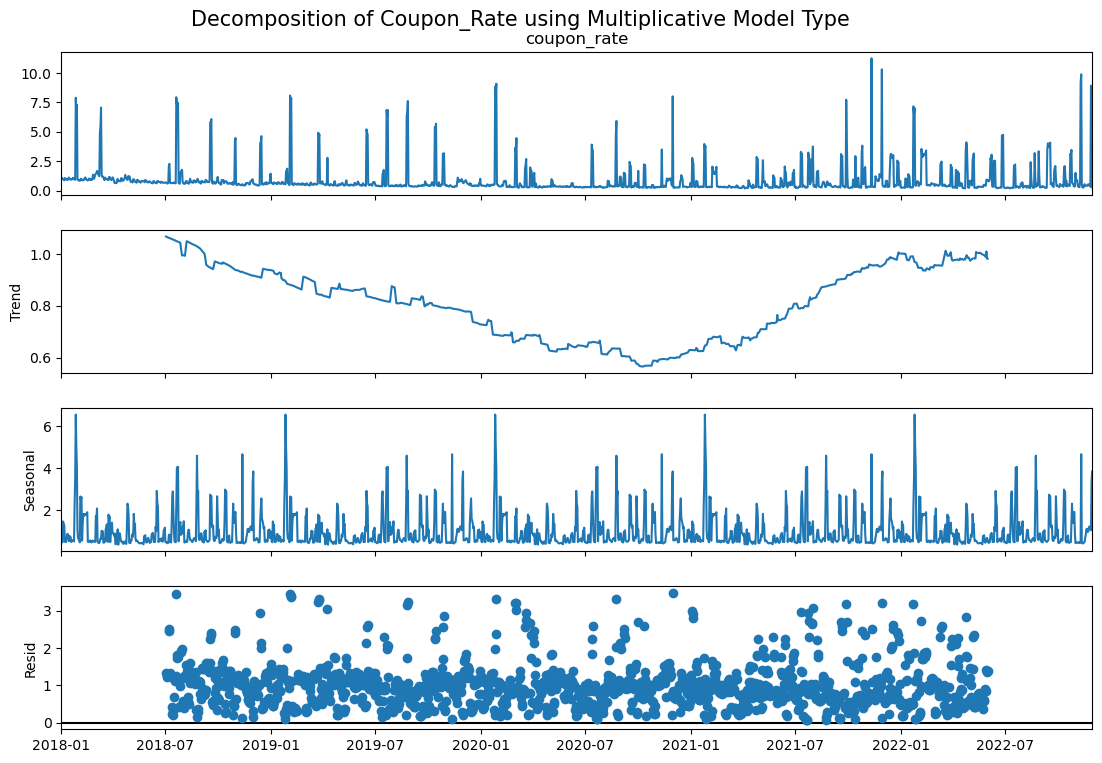

In [19]:
decompose(df, 'coupon_rate', model='mul')

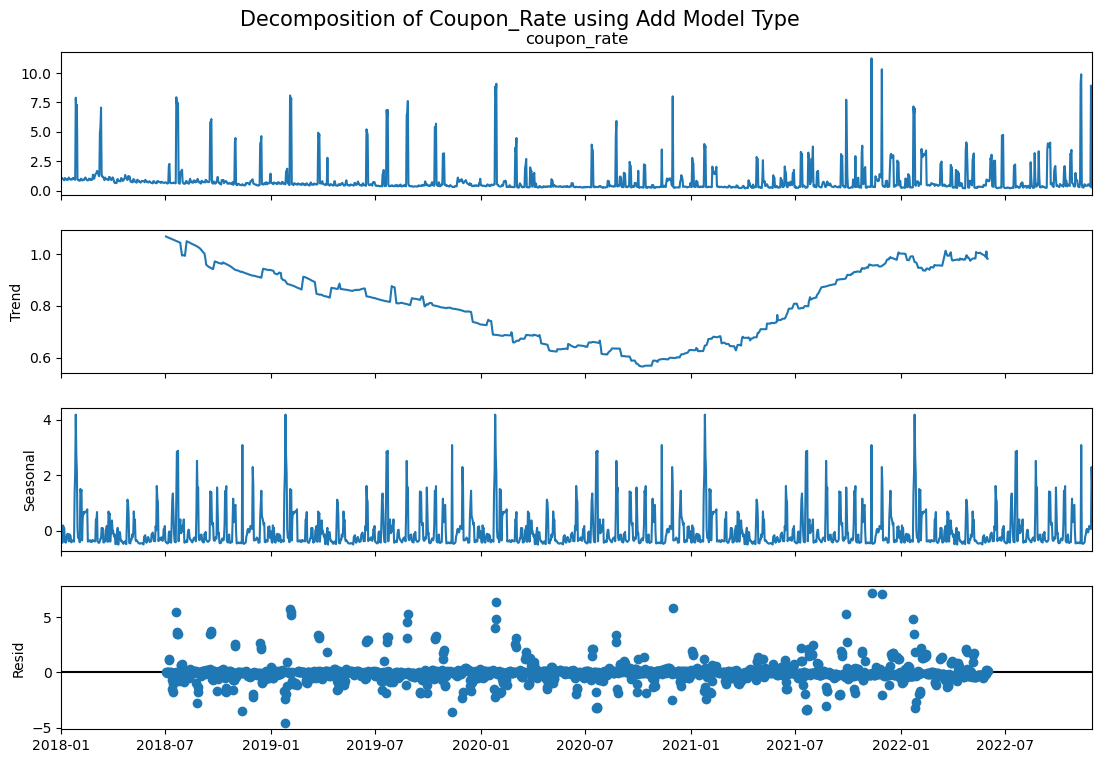

In [20]:
decompose(df, 'coupon_rate', model='add')

## Check Stationarity and Autocorrelations

In [21]:
from statsmodels.tsa.stattools import adfuller, kpss

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
def check_stationarity(df, column_name='revenue', alpha=.05, diff = 0):
    df = df.copy()
    if diff != 0:
        df = df.diff(diff)
        df = df.dropna()
    
    adf_res = adfuller(df[column_name])
    kpss_res = kpss(df[column_name])
    
    print('p-value ADF : %f' % adf_res[1])
    print('p-value KPSS: %f' % kpss_res[1])
    
    # Interpreting the results
    if (adf_res[1] < alpha) & (kpss_res[1] > alpha):
        print("Evidence suggests that the time series is stationary.")
    else:
        print("Evidence suggests that the time series is not stationary.")

    fig, ax = plt.subplots(1,1,figsize=(12,6))
    
    df[column_name].plot(ax=ax)
    
    column_name = column_name.replace("_", " ").title()
    plt.suptitle(f"{column_name} Plot with Diff={diff}", size=16)
    plt.show();

In [22]:
def plot_autocorrelations(df, column_name='revenue', lags=730, diff = 0):
    df = df.copy()
    if diff != 0:
        df = df.diff(diff)
        df = df.dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    
    plot_acf(df[column_name], lags=lags, ax=ax1)
    plot_pacf(df[column_name], lags=lags, ax=ax2)
    
    plt.suptitle(f"ACF dan PACF Plots for {column_name.title()} Weekly Data, [Diff={diff}, Lags={lags}]", size=16)
    plt.tight_layout()
    plt.show();

### 1. Revenue
#### Revenue, diff=0

C:\Users\HP\AppData\Local\Temp\ipykernel_7452\2762609248.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(df[column_name])


p-value ADF : 0.101904
p-value KPSS: 0.010000
Evidence suggests that the time series is not stationary.


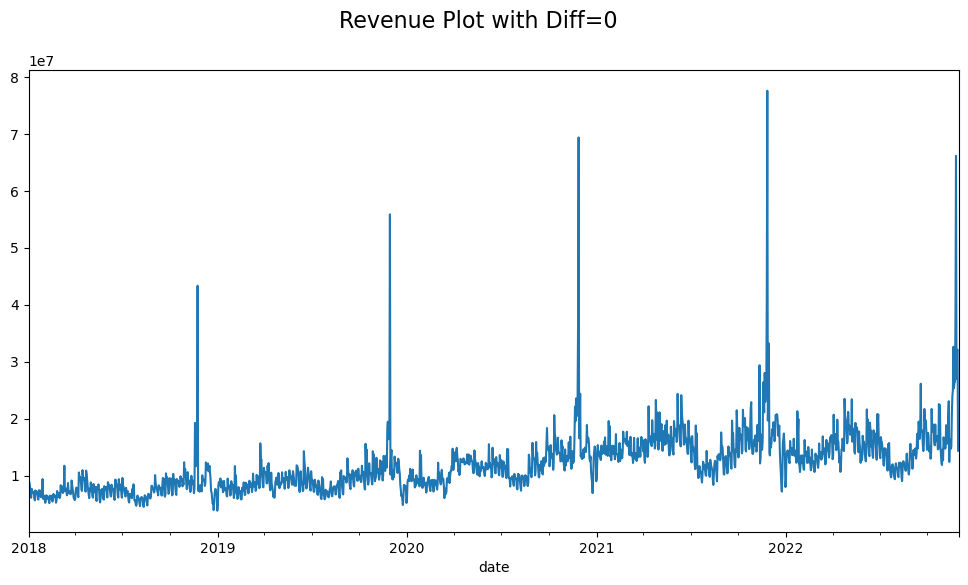

In [23]:
# for Revenue
check_stationarity(df)

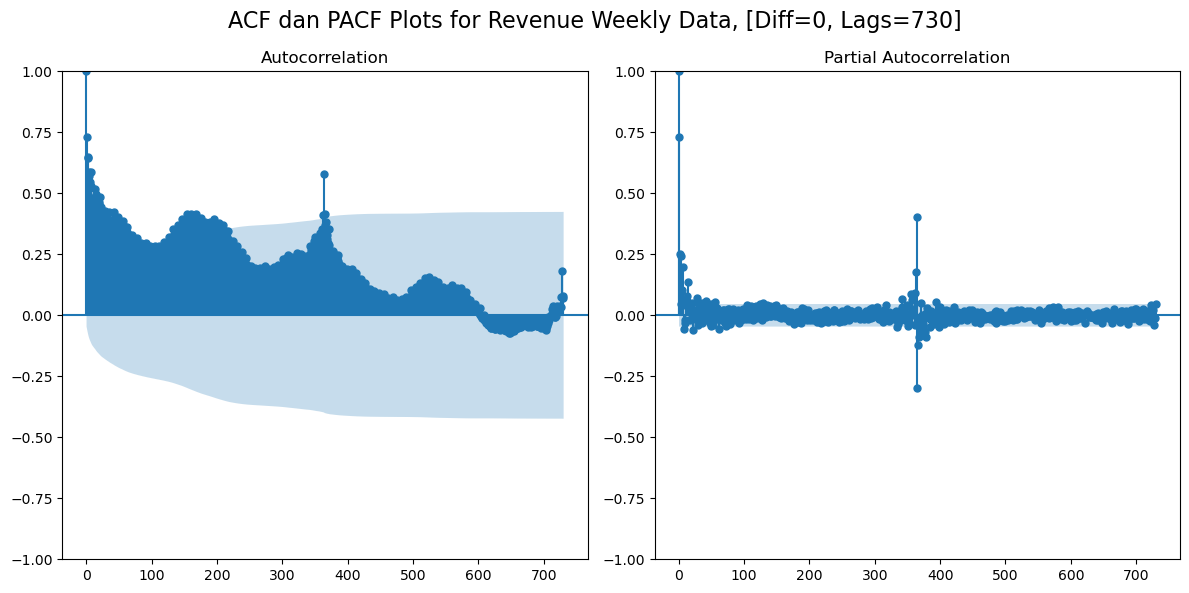

In [24]:
plot_autocorrelations(df)

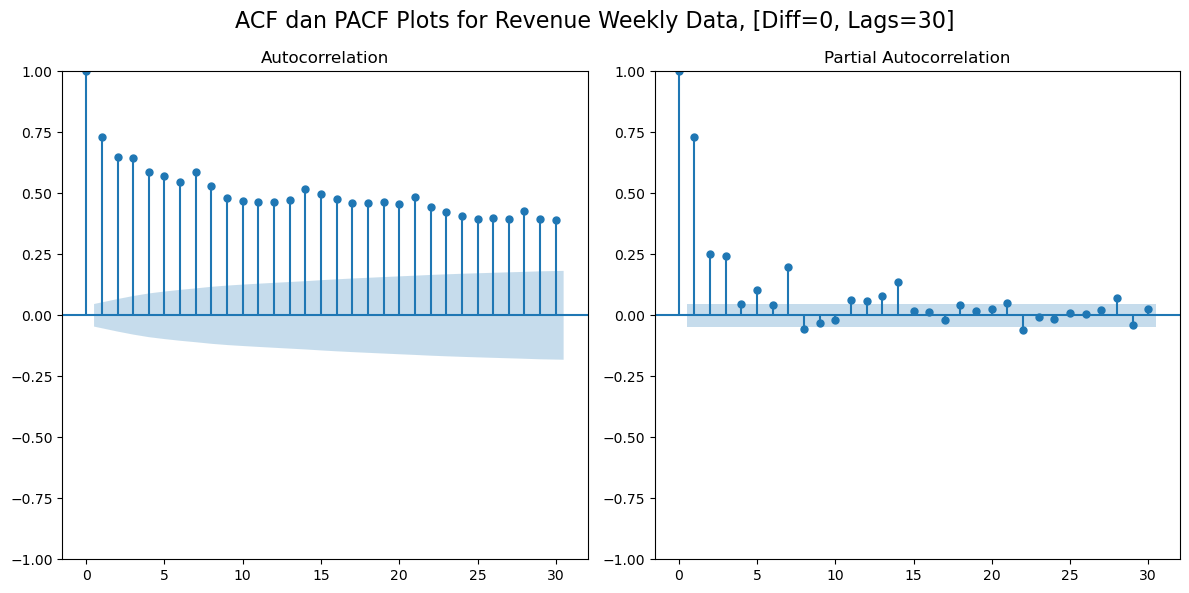

In [25]:
plot_autocorrelations(df, lags=30)

#### Revenue, diff=1

C:\Users\HP\AppData\Local\Temp\ipykernel_7452\2762609248.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


p-value ADF : 0.000000
p-value KPSS: 0.100000
Evidence suggests that the time series is stationary.


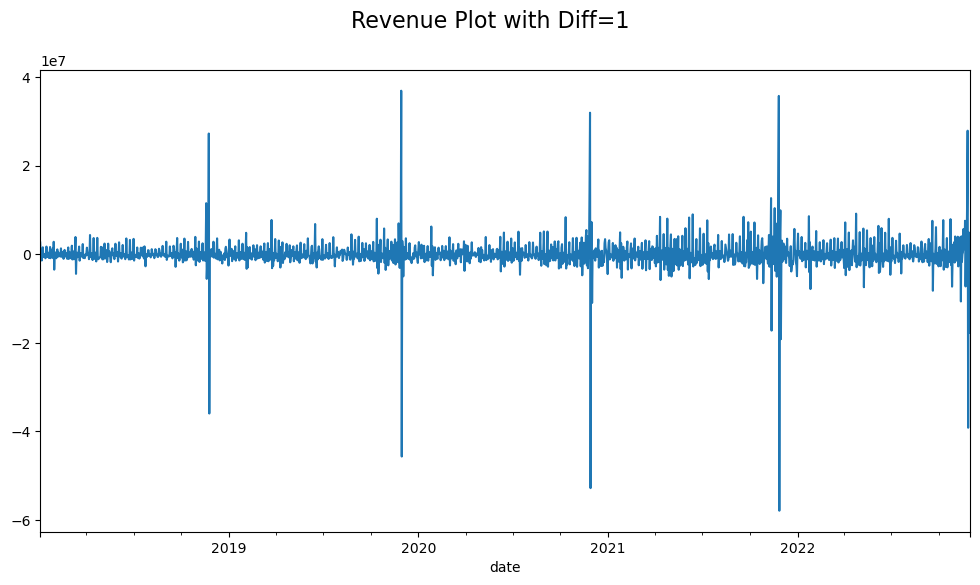

In [26]:
# for Revenue
check_stationarity(df, diff=1)

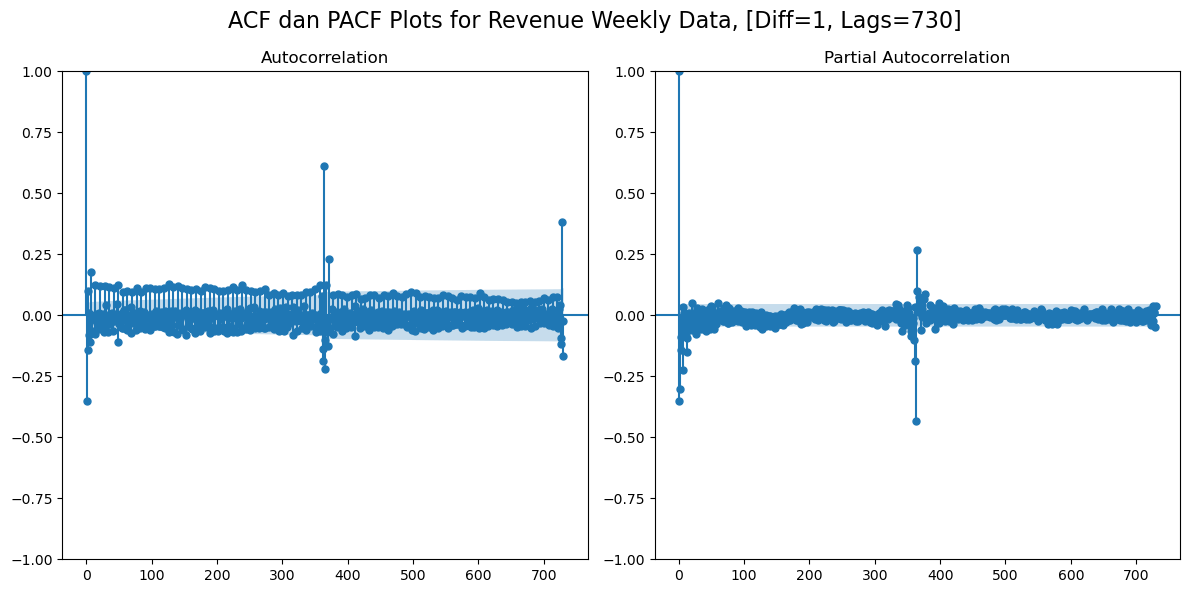

In [27]:
plot_autocorrelations(df, lags=730, diff=1)

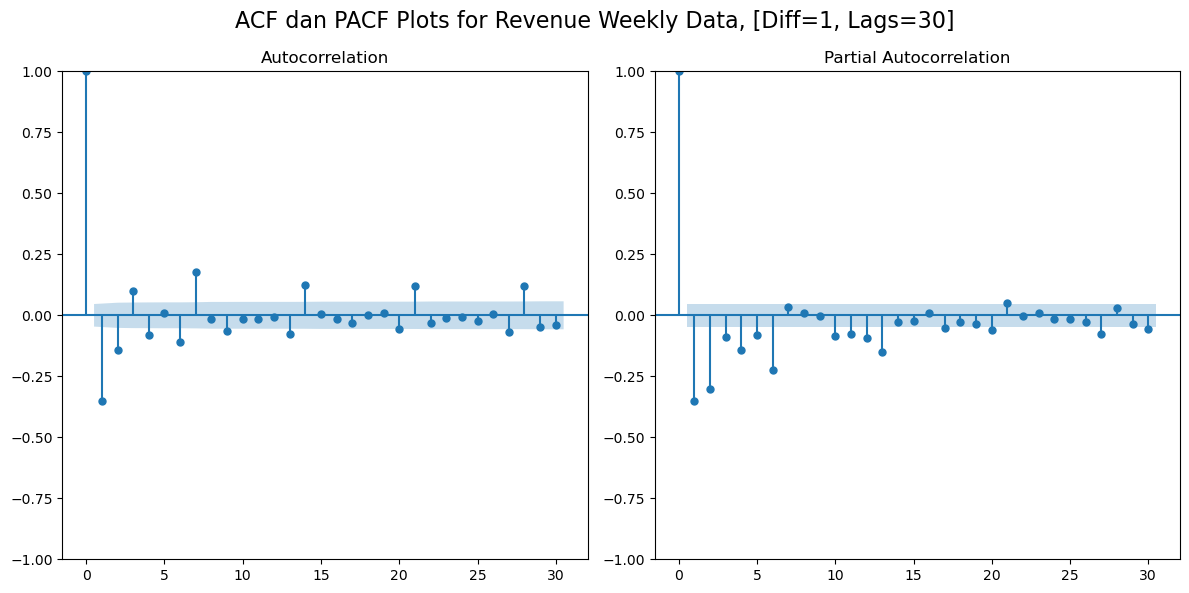

In [28]:
plot_autocorrelations(df, lags=30, diff=1)

### 2. Discount Rate
#### Discount Rate, diff=0

p-value ADF : 0.000001
p-value KPSS: 0.018064
Evidence suggests that the time series is not stationary.


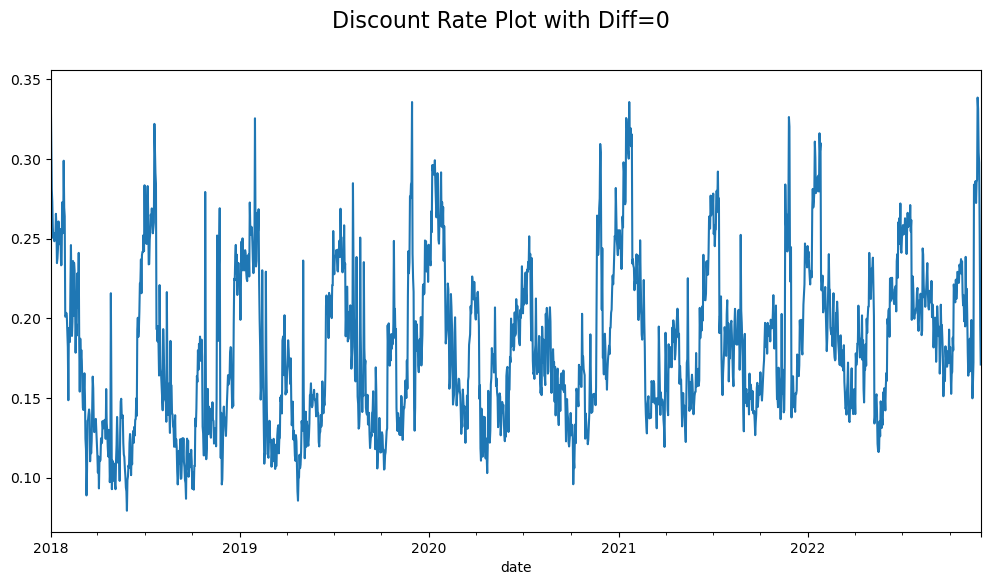

In [29]:
# for Discount Rate
check_stationarity(df, 'discount_rate')

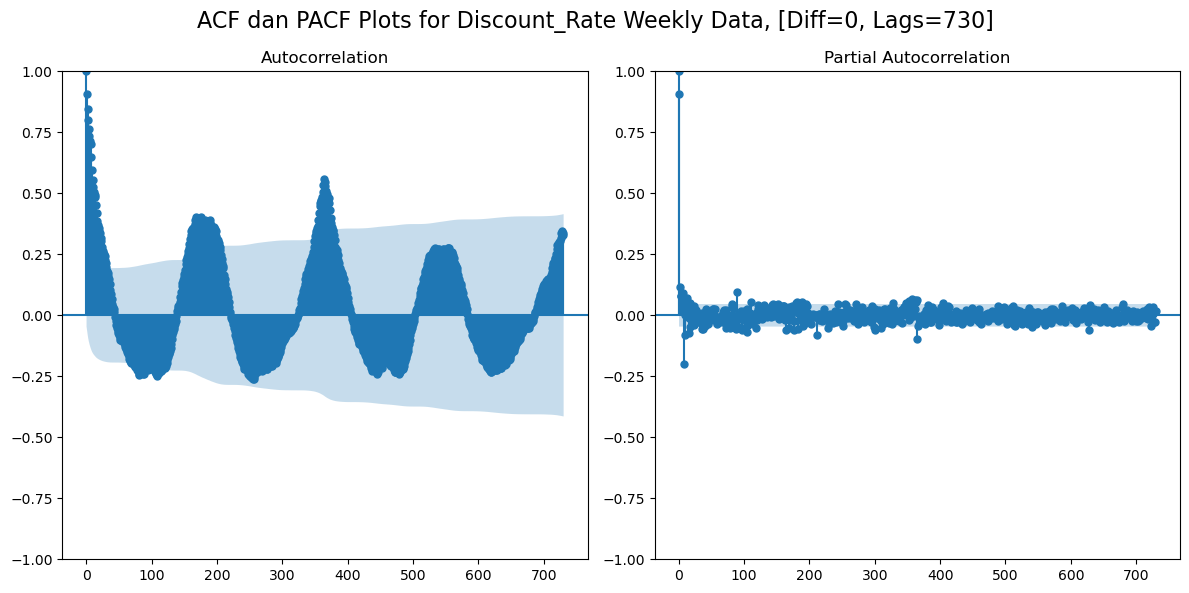

In [30]:
plot_autocorrelations(df, 'discount_rate')

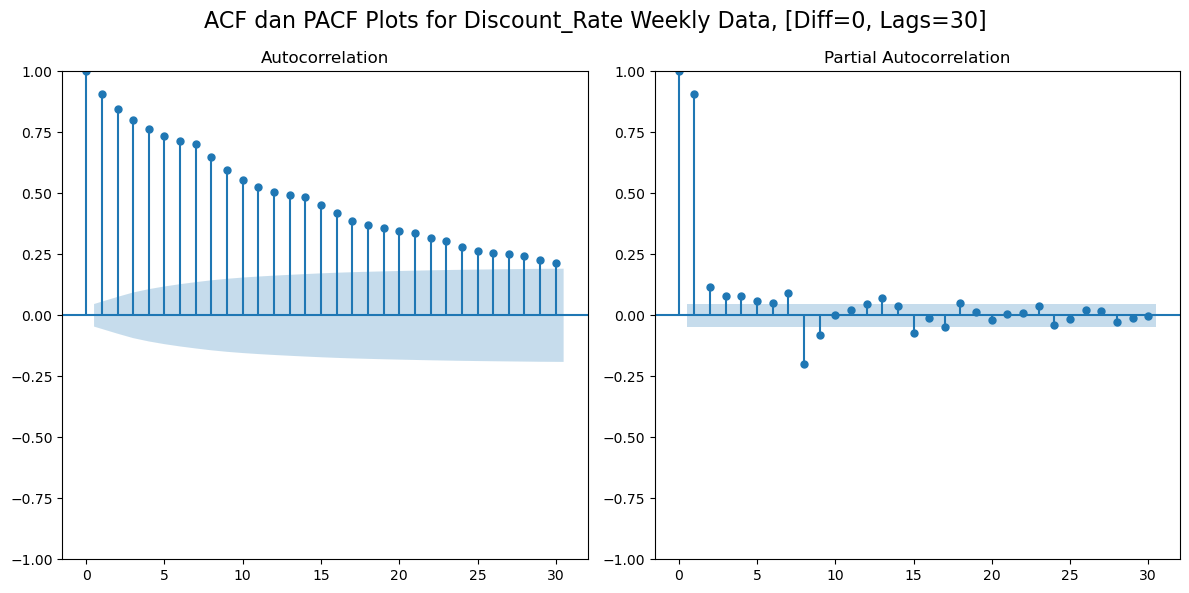

In [31]:
plot_autocorrelations(df, 'discount_rate', lags=30)

#### Discount Rate, diff=1

C:\Users\HP\AppData\Local\Temp\ipykernel_7452\2762609248.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


p-value ADF : 0.000000
p-value KPSS: 0.100000
Evidence suggests that the time series is stationary.


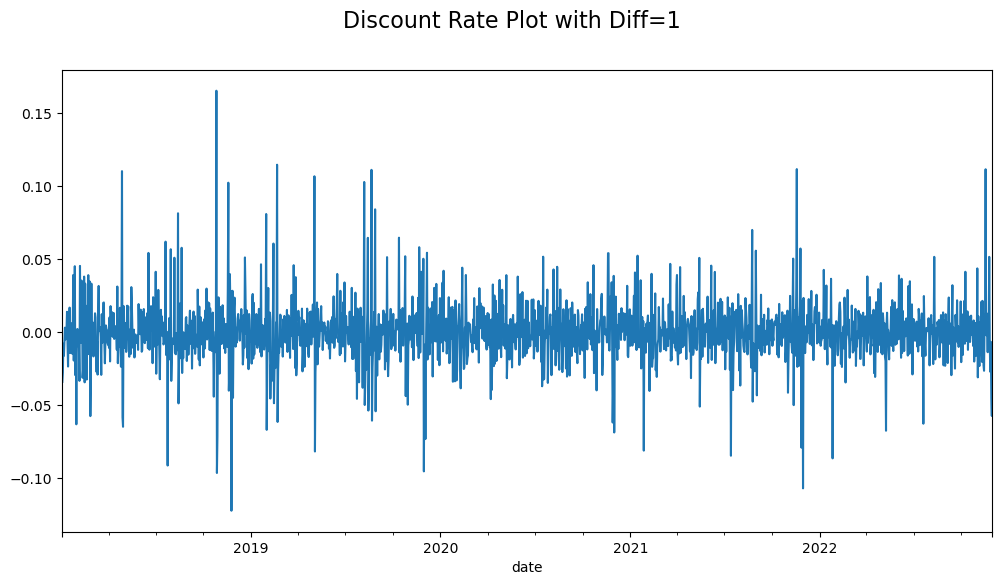

In [32]:
# for Discount Rate
check_stationarity(df, 'discount_rate', diff=1)

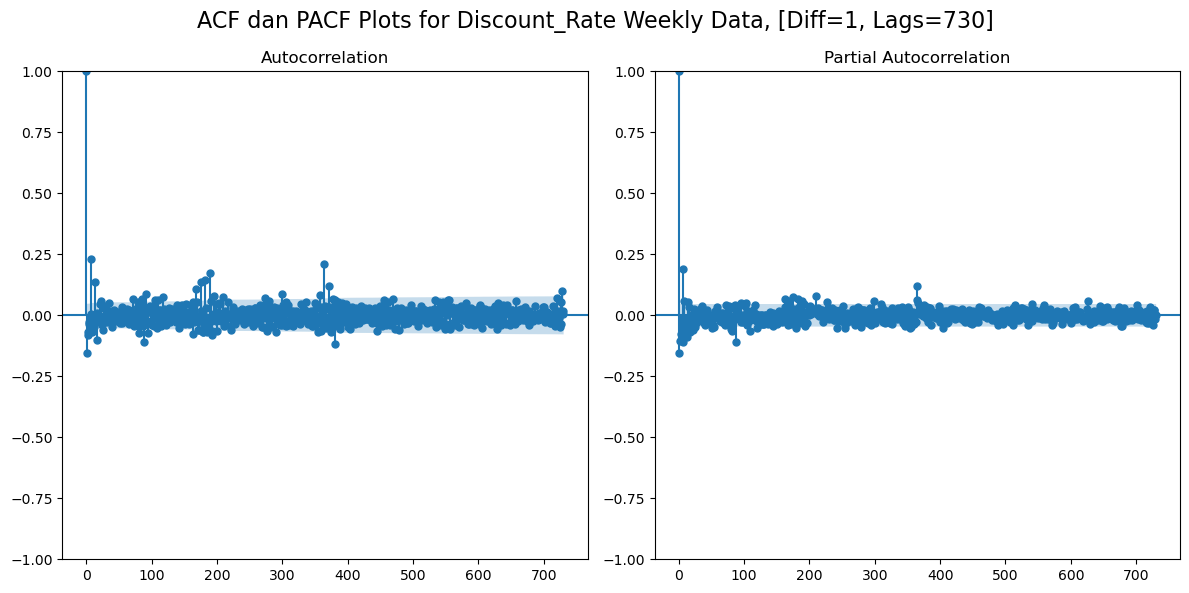

In [33]:
plot_autocorrelations(df, 'discount_rate', diff=1)

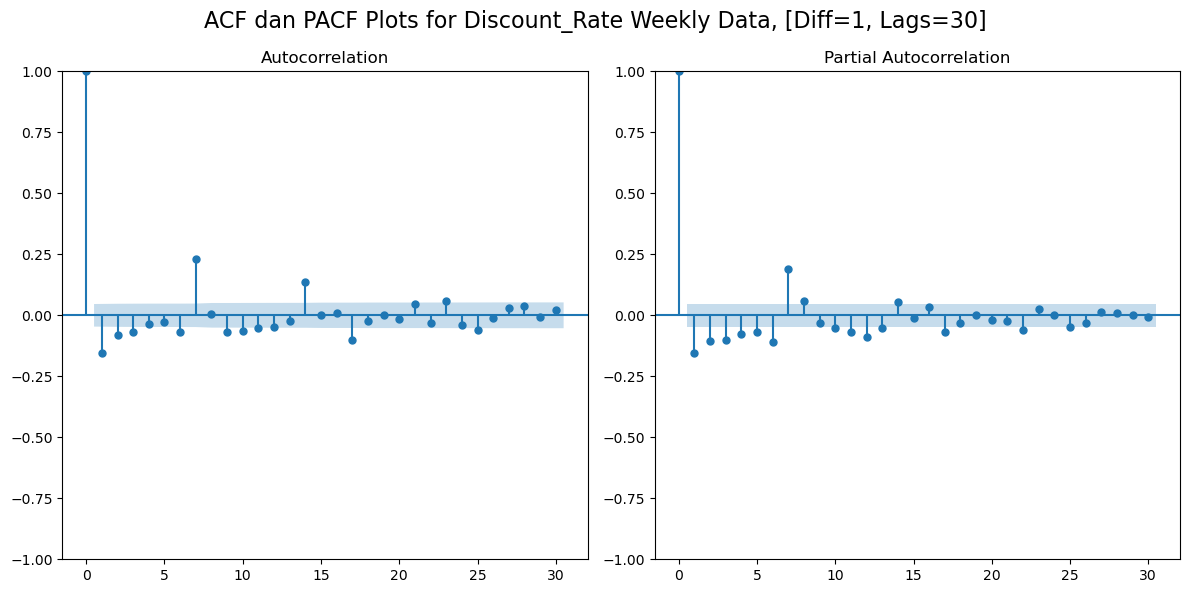

In [34]:
plot_autocorrelations(df, 'discount_rate', lags=30, diff=1)

### 3. Coupon Rate

#### Coupon Rate, diff = 0

p-value ADF : 0.000000
p-value KPSS: 0.049043
Evidence suggests that the time series is not stationary.


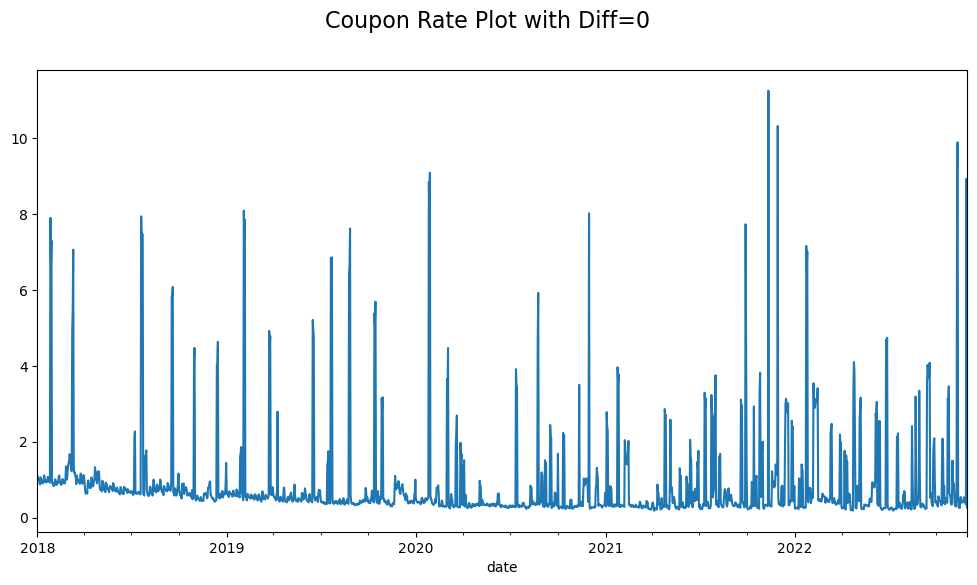

In [35]:
# for Discount Rate
check_stationarity(df, 'coupon_rate')

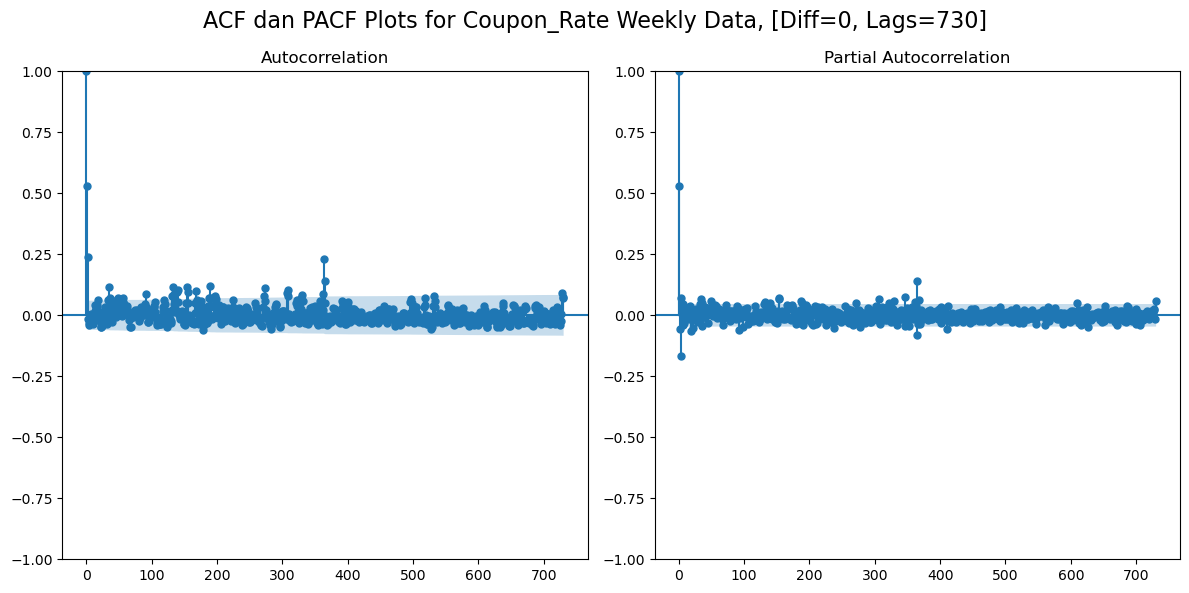

In [36]:
plot_autocorrelations(df, 'coupon_rate')

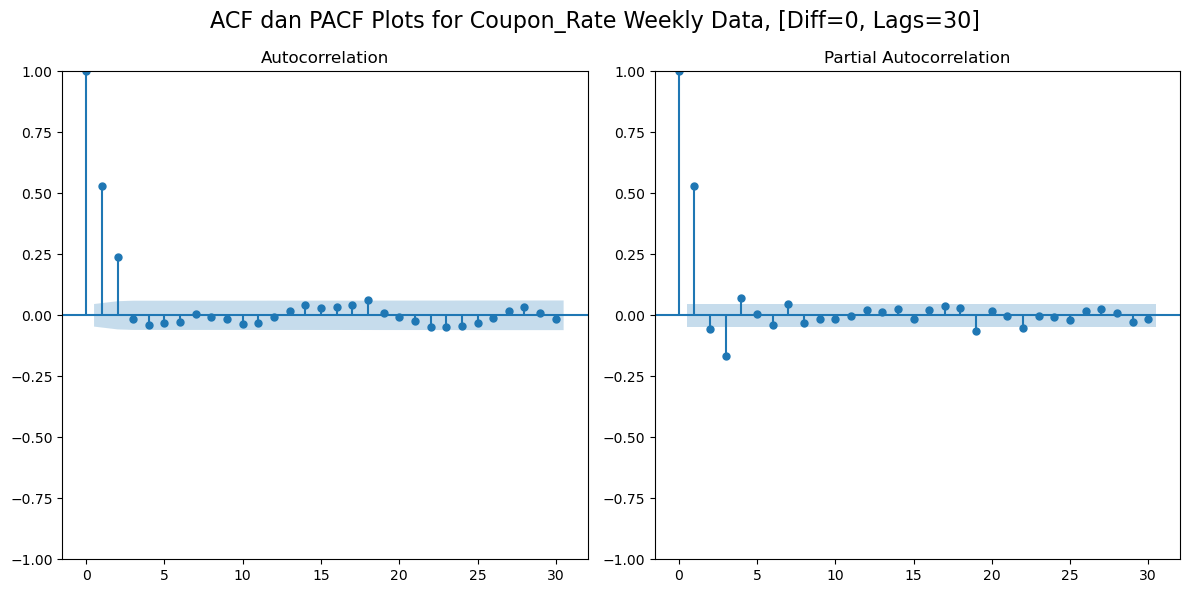

In [37]:
plot_autocorrelations(df, 'coupon_rate', lags=30)

#### Coupon Rate, diff=1

C:\Users\HP\AppData\Local\Temp\ipykernel_7452\2762609248.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


p-value ADF : 0.000000
p-value KPSS: 0.100000
Evidence suggests that the time series is stationary.


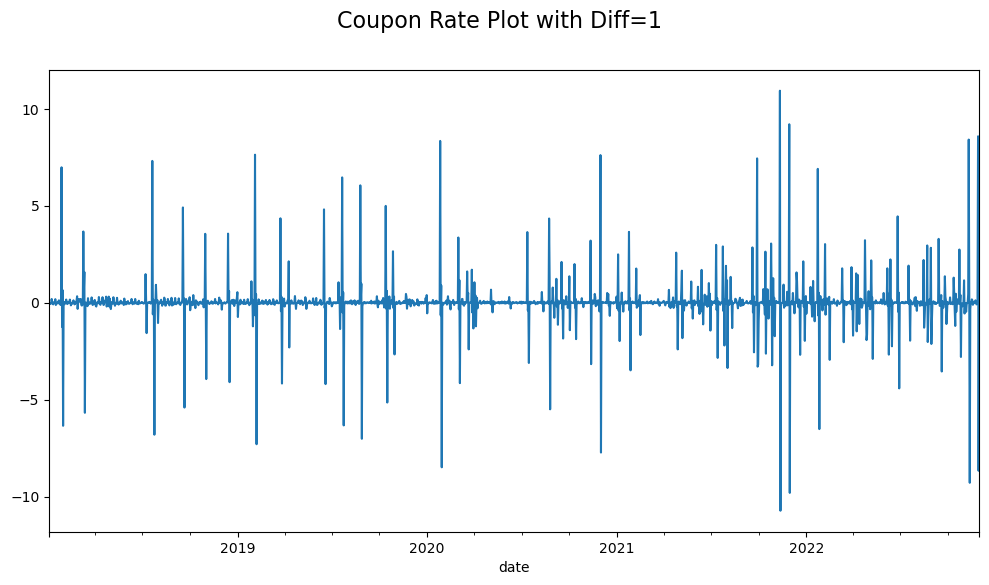

In [38]:
check_stationarity(df, 'coupon_rate', diff=1)

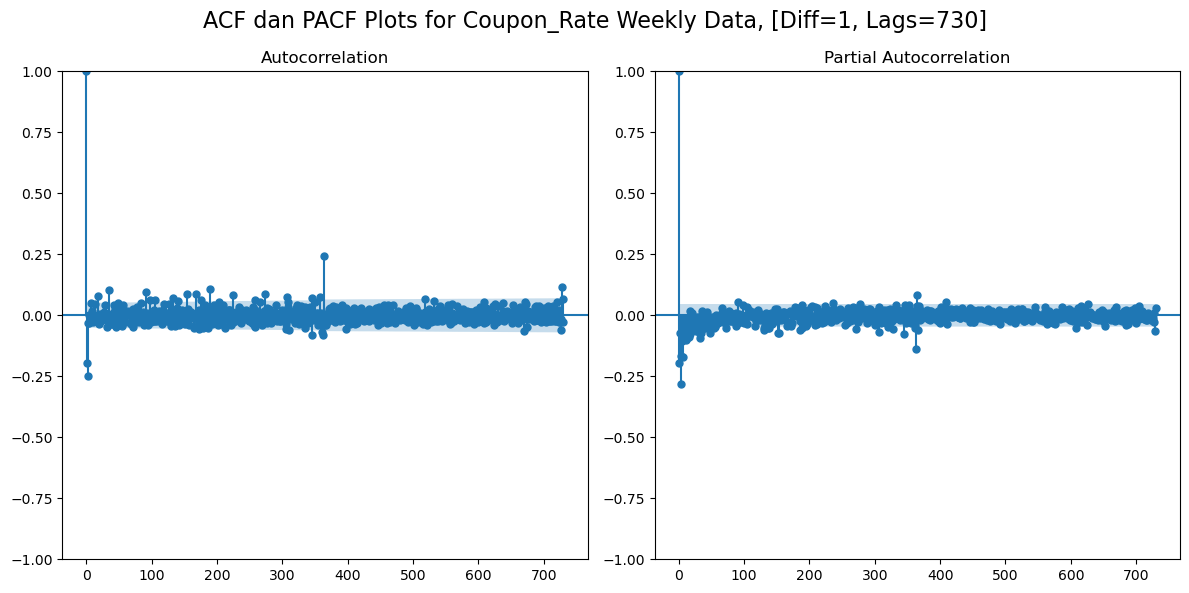

In [39]:
plot_autocorrelations(df, 'coupon_rate', diff=1)

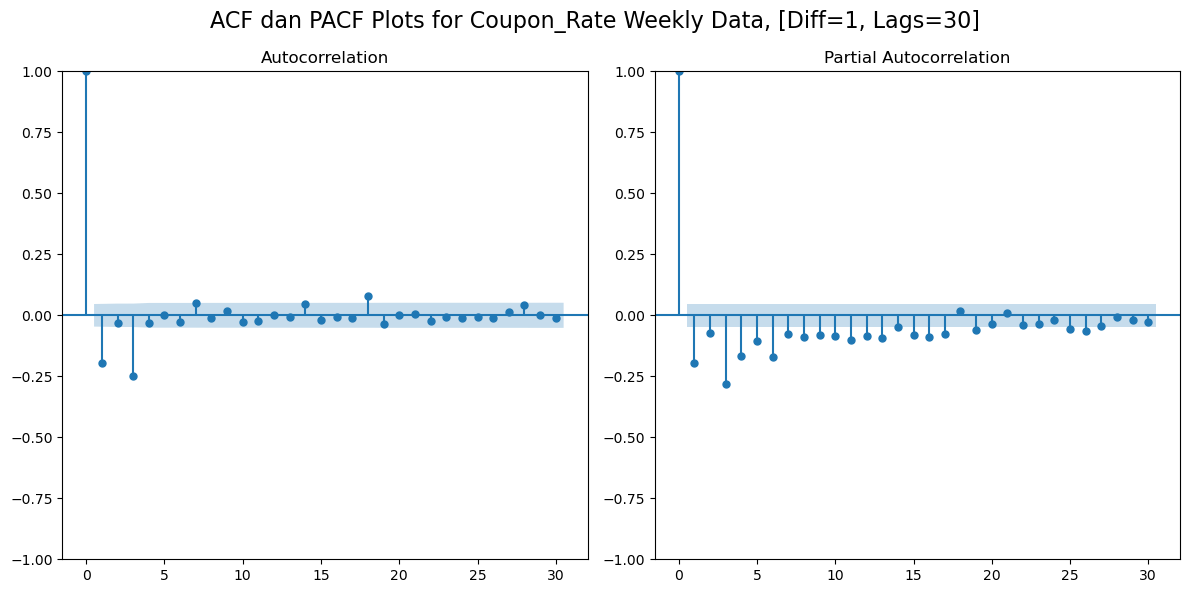

In [40]:
plot_autocorrelations(df, 'coupon_rate', lags=30, diff=1)

##

## Check Trend and Seasonality

In [41]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

In [42]:
def plot_seasonal(df, column_name='revenue', figsize=(12, 4)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize, sharey=True)
    
    month_plot(df[column_name].resample('ME').mean(), 
               ax=ax1)
    quarter_plot(df[column_name].resample('QE').mean(), 
                 ax=ax2)
    
    ax1.set_title("Monthly Plot", size=int(figsize[0]))
    ax2.set_title("Quarterly Plot", size=int(figsize[0]))
    plt.suptitle(f"Seasonal Plot of {column_name.title()}", size=int(1.3*figsize[0]))
    plt.tight_layout()
    plt.plot();

In [43]:
def decompose(df, column_name='revenue', model = 'mul', period=365,
              figsize=(12, 4)):
    # Seasonal Decomposition Plots for complaint values
    # Multiplicative model type, with yearly seasonality (52 weeks)
    
    decomposition = seasonal_decompose(df[column_name],
                                       model = model,
                                       period = period)
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    
    if (model == 'mul') or (model == 'muliplicative'):
        model = 'Multiplicative'
    else: model = 'Additive'
    
    fig.suptitle(f"Decomposition of {column_name.title()} using {model.title()} Model Type",size=int(1.3*figsize[0]))
    plt.show()

In [44]:
def check_seasonality(df, col = 'revenue', m = 183, return_result = False, print_result=True):
    """
    Function to check for seasonality at lag m using Ljung-Box test.
    """
    # Perform the Ljung-Box test at lag m
    lb_test = acorr_ljungbox(df[col], lags=[m], return_df=True)
    
    if print_result:
        print("Ljung-Box Test at lag:", m)
        print(lb_test)
        if lb_test['lb_pvalue'].values[0] < 0.05:
            print(f"Significant seasonality detected at lag {m} (p-value: {lb_test['lb_pvalue'].values[0]:.4f})")
        else:
            print(f"No significant seasonality detected at lag {m} (p-value: {lb_test['lb_pvalue'].values[0]:.4f})")

    if return_result:
        return lb_test

def inspect_seasonality(df, col = 'revenue', m_list = [7, 30, 183, 365]):
    # create result dataframe
    res = pd.DataFrame()
    
    # inspect for all period list
    for m in m_list:
        row = check_seasonality(df, col, m=m, return_result = True, print_result=False)
        res = pd.concat([res, row])
        
    # present result
    res = res.reset_index()
    res.rename(columns={
        'index' : 'period'
    }, inplace=True)
    res['rank'] = res['lb_stat'].rank(ascending=False)
    res.sort_values(by='rank', axis=0, ascending=True, inplace=True)
    
    return res

### Revenue Seasonal

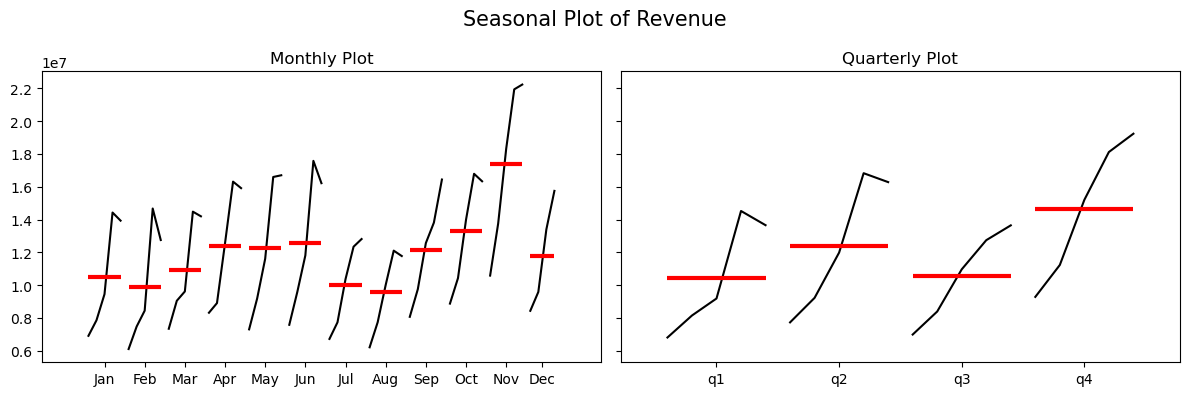

In [45]:
plot_seasonal(df, 'revenue')

In [46]:
inspect_seasonality(df, col = 'revenue')

,period,lb_stat,lb_pvalue,rank
3,365,72813.242117,0.0,1.0
2,183,46231.680657,0.0,2.0
1,30,13401.633083,0.0,3.0
0,7,4839.141572,0.0,4.0


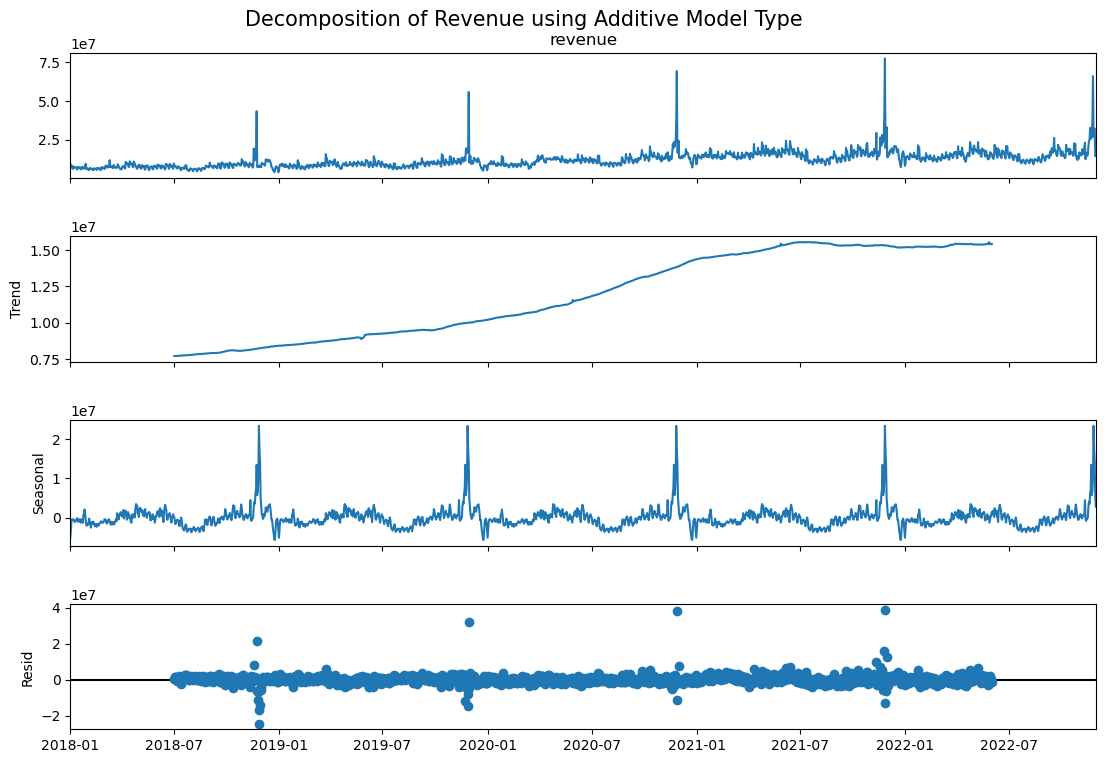

In [47]:
decompose(df, 'revenue', model='add', period=365)

### Discount Rate Seasonal

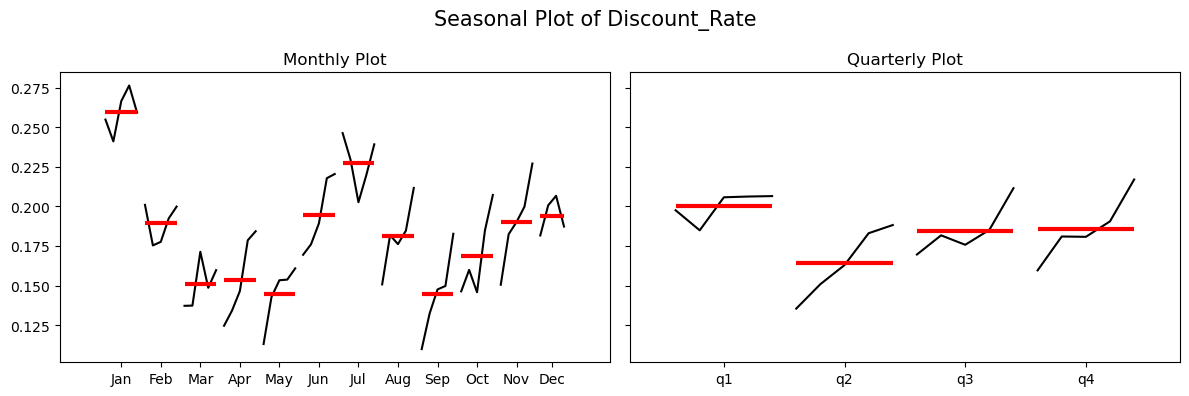

In [48]:
plot_seasonal(df, 'discount_rate')

In [49]:
inspect_seasonality(df, col = 'discount_rate')

,period,lb_stat,lb_pvalue,rank
3,365,50456.827234,0.0,1.0
2,183,29155.663961,0.0,2.0
1,30,14573.681920,0.0,3.0
0,7,7763.194091,0.0,4.0


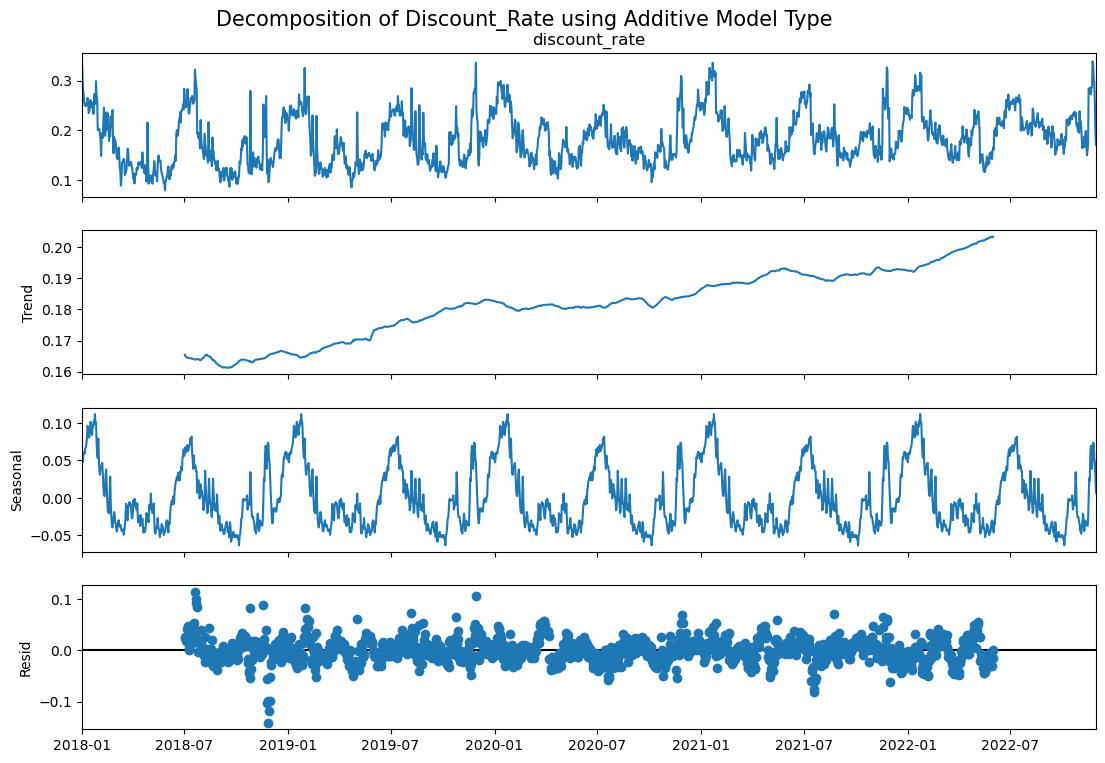

In [50]:
decompose(df, 'discount_rate', model='add', period=365)

### Coupon Rate Seasonal

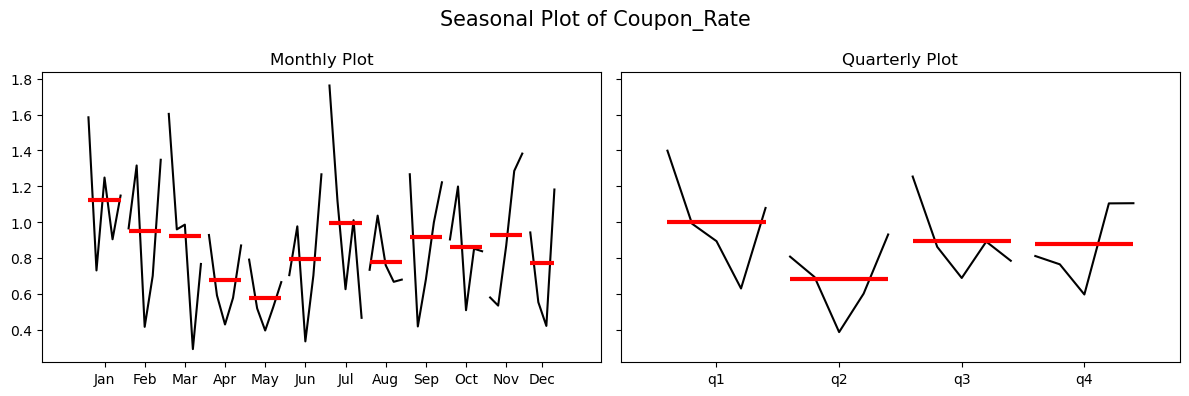

In [51]:
plot_seasonal(df, 'coupon_rate')

In [52]:
inspect_seasonality(df, col = 'coupon_rate')

,period,lb_stat,lb_pvalue,rank
3,365,1746.714359,8.764944e-179,1.0
2,183,1121.758934,1.291875e-134,2.0
1,30,654.069427,1.792561e-118,3.0
0,7,613.034867,3.795567e-128,4.0


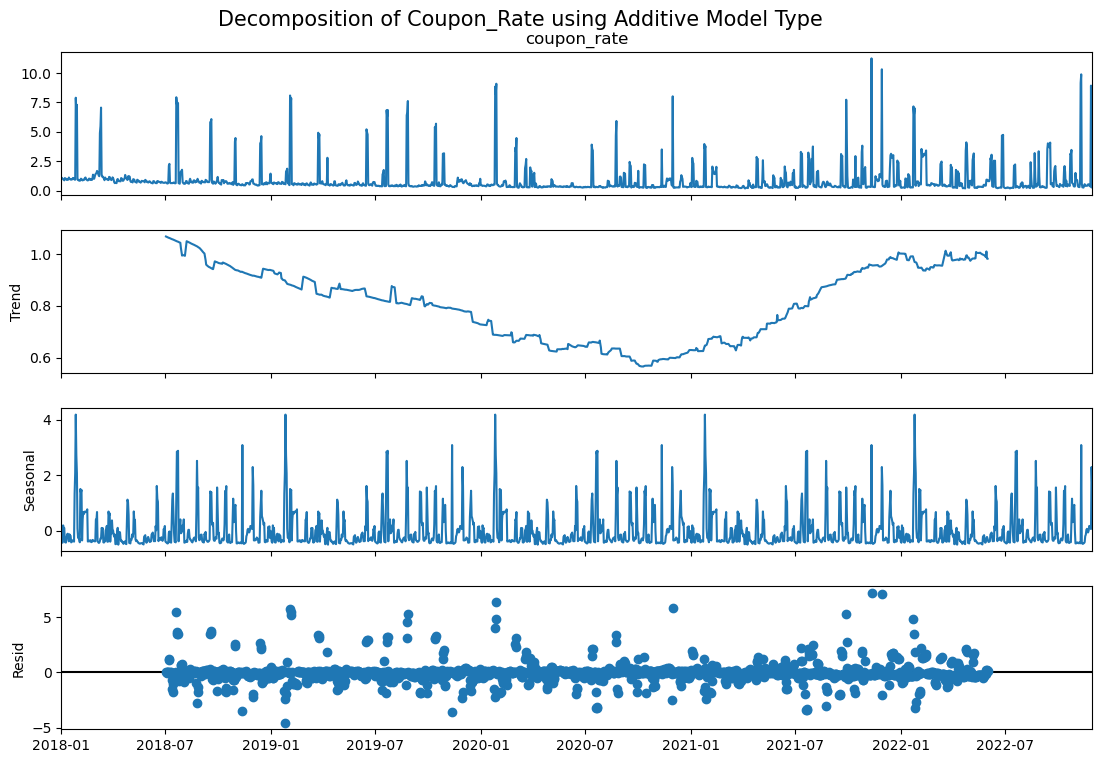

In [53]:
decompose(df, 'coupon_rate', model='add', period=365)

## Insight:

**Revenue:**
1. Additive trend, additive seasonal
2. No strong correlation between Revenue-discount rate, and Revenue-Coupon Rate. (Pearson corr: <.4)
3. Has 365 days seasonal

**Discount Rate:**
1. Additive trend, additive seasonal
2. No strong correlation between Discount rate-Coupon Rate. (Pearson corr: <.4)
3. Has 365 days seasonal

**Coupon Rate:**
1. Additive trend, additive seasonal
2. No strong correlation between Discount rate-Coupon Rate. (Pearson corr: <.4)
3. Has 365 days seasonal

# Parameter Tuning

In [189]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from pmdarima import auto_arima

In [186]:
# Defining the parameters
param_grid = {'p': [1,2,3,4,5,6,7],
              'd': [1],
              'q': [1,2,3],
              'P': [1,2],
              'D': [0],
              'Q': [1,2]}
grid = ParameterGrid(param_grid)
len(list(grid))

72

In [213]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Sample data (replace with your time series data)
np.random.seed(42)
n_periods = 200
trend = np.arange(n_periods) * 0.1
noise = np.random.normal(0, 1, n_periods)
data = trend + noise
df = pd.DataFrame({'data': data})

# ADF Test Function
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # return p-value

# Determine non-seasonal differencing (d)
d = 0
while adf_test(df['data'].dropna()) > 0.05:
    d += 1
    df['data'] = df['data'].diff().dropna()
print(f'Optimal non-seasonal differencing (d): {d}')

# Seasonal differencing (D) for seasonality (assuming period m=12)
m = 12
df['seasonal_diff'] = df['data'].diff(m).dropna()

# ADF test on seasonally differenced data
if adf_test(df['seasonal_diff'].dropna()) < 0.05:
    print(f'Optimal seasonal differencing (D): 1')
else:
    print(f'Seasonal differencing (D) might need to be greater than 1')


Optimal non-seasonal differencing (d): 1
Optimal seasonal differencing (D): 1


<AxesSubplot:>

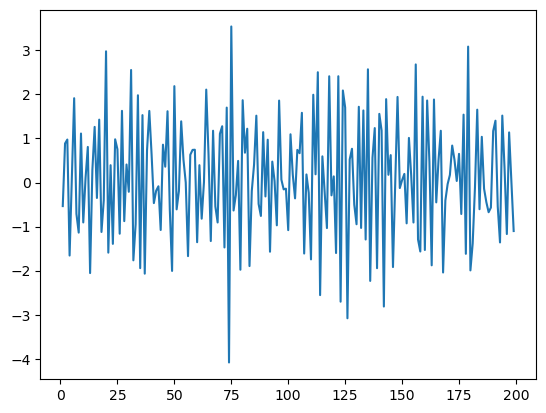

In [216]:
df['data'].plot()

In [220]:
df = df.dropna()

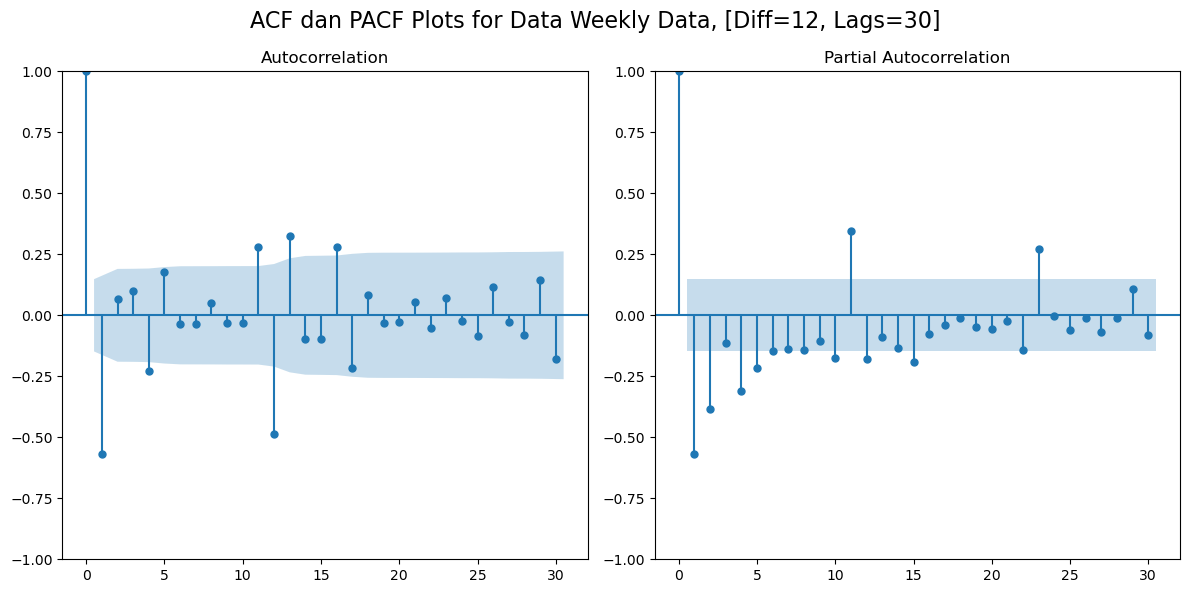

In [223]:
plot_autocorrelations(df, 'data', lags=30, diff=12)